# Likelihood scan for CMB parameterization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our modules
import camb_cosmo
import CAMB_model
import full_theory
import likelihood
import data_MPGADGET
import gp_emulator
import p1d_arxiv
import iminuit_minimizer
import grid_scanner

Setup mock data, from one of simulations in the suite

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label=30
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

will drop sim number 30 from emulator


In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4.0
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max)

read cosmology from GenIC /Users/font/Projects/LyaCosmoParams//p1d_emulator/sim_suites/Australia20/sim_pair_30/sim_plus/paramfile.genic
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


Setup archive of P1D measurements from simulations to train the emulator

In [4]:
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
# specify parameters to be used in emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
# setup GP emulator
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Library/Python/3.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Setup FullTheory, explicit in case we don't use any cosmo param and likelihood gets confused

In [6]:
# specify whether to use true cosmology in simulation as fiducial (easier test)
use_sim_fid=False
if use_sim_fid:
    sim_cosmo=data.mock_sim.sim_cosmo
    print('use true cosmo as fiducial')
    camb_cosmo.print_info(sim_cosmo)
    camb_model_sim=CAMB_model.CAMBModel(zs=data.z,cosmo=sim_cosmo)
    theory=full_theory.FullTheory(zs=data.z,emulator=emu,camb_model_fid=camb_model_sim)
else:
    theory=full_theory.FullTheory(zs=data.z,emulator=emu)
    print('use default cosmo as fiducial')
    camb_cosmo.print_info(theory.camb_model_fid.cosmo)

use default cosmo as fiducial
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


Setup likelihood and free parameters

In [7]:
# Likelihood parameters (option to fix cosmology)
fix_cosmo=False
if fix_cosmo:
    assert use_sim_fid,'do you want to fix the cosmology when not using the right one?'
    like_params=["ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
    like_param_limits=[[-0.2, 0.2],[-0.5, 0.5],[-0.2, 0.2]]
else:
    like_params=["As","ns","ln_tau_0","ln_sigT_kms_0","ln_gamma_0"]
    like_param_limits=[[1.0e-9,3.0e-9 ], [0.90, 1.00], [-0.2, 0.2],
            [-0.5, 0.5], [-0.2, 0.2]]

In [8]:
like=likelihood.Likelihood(data=data,theory=theory,
                            free_param_names=like_params,
                            free_param_limits=like_param_limits,
                            verbose=False,
                            prior_Gauss_rms=0.5)

In [9]:
## Evaluate log_prob at random point in parameter space
theta=np.ones(len(like_params))*0.5 ## Just pick the middle of likelihood space
print('starting point')
for par in like.parameters_from_sampling_point(theta):
    print(par.info_str())
chi2_test=like.get_chi2(theta)
print('starting chi2',chi2_test)

starting point
As = 1.9999999999999997e-09
ns = 0.95
ln_tau_0 = 0.0
ln_sigT_kms_0 = 0.0
ln_gamma_0 = 0.0
starting chi2 15.957100606447703


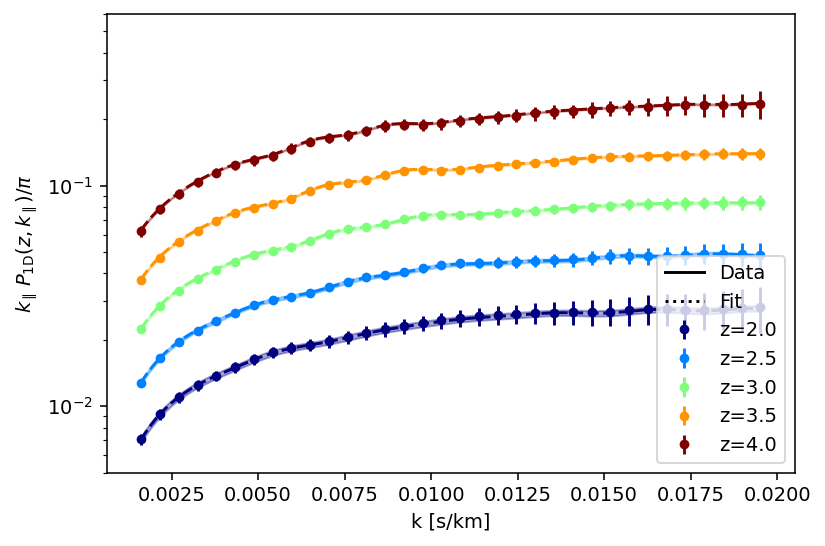

In [10]:
like.plot_p1d(plot_every_iz=2)

### Setup our own minimizer

In [11]:
minimizer = iminuit_minimizer.IminuitMinimizer(like)

will run migrad
------------------------------------------------------------------
| FCN = 34.42                   |     Ncalls=175 (175 total)     |
| EDM = 6.67e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
will compute Hessian matrix
best-fit values = [0.47733325 0.61058843 0.54056164 0.45860973 0.58181012]


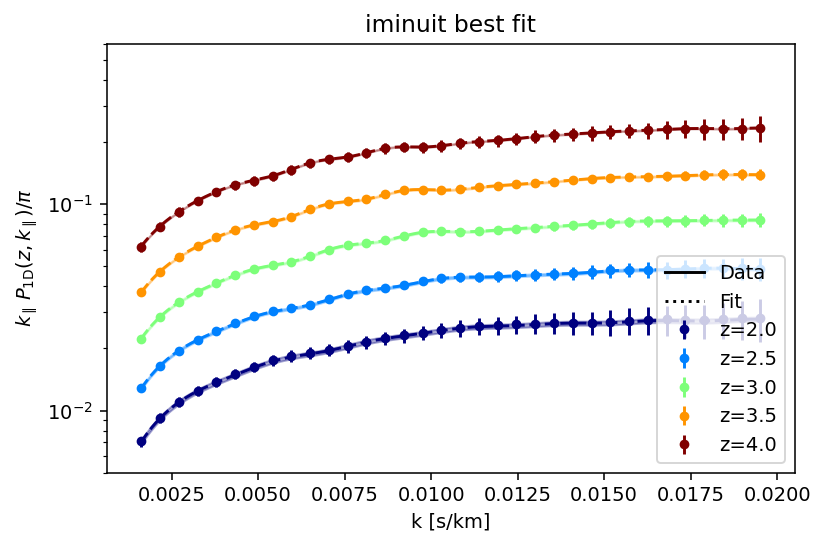

In [12]:
minimizer.minimize()
minimizer.plot_best_fit(plot_every_iz=2)

In [13]:
best_fit=minimizer.minimizer.np_values()
print('best-fit values',best_fit)

best-fit values [0.47733325 0.61058843 0.54056164 0.45860973 0.58181012]


### Setup a 1D chi2 scan

In [14]:
N=11
true_ns=data.mock_sim.sim_cosmo.InitPower.ns
grid={'name':'ns','minval':true_ns-0.03,'maxval':true_ns+0.03,'nval':N}
scan1D=grid_scanner.Scan1D(like,param_grid=grid)
# compute actual scan (might be slow)
_=scan1D.get_grid_scan()

will compute grid scan
will run migrad
------------------------------------------------------------------
| FCN = 34.42                   |     Ncalls=175 (175 total)     |
| EDM = 6.67e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
global chi2 = 0.7901801016989698 ; best-fit = [0.47733325 0.61058843 0.54056164 0.45860973 0.58181012]
1 ns 0.937565 in cube 0.3756499999999997
will run migr

------------------------------------------------------------------
| FCN = 40.18                   |     Ncalls=167 (167 total)     |
| EDM = 1.45e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
1 ns 0.997565 in cube 0.9756500000000004
will run migrad
------------------------------------------------------------------
| FCN = 42.04                   |     Ncalls=227 (227 total)     |
| EDM

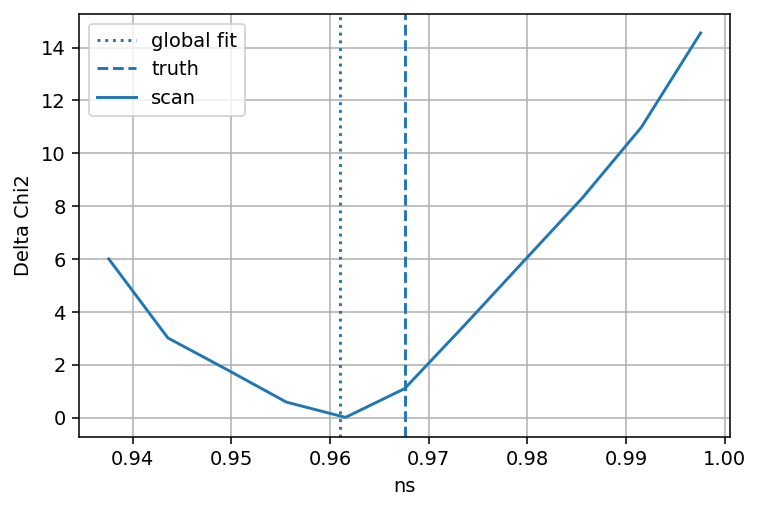

In [15]:
scan1D.plot_grid_scan(true_value=true_ns)

In [16]:
N=11
true_As=data.mock_sim.sim_cosmo.InitPower.As
grid={'name':'As','minval':true_As-4e-10,'maxval':true_As+4e-10,'nval':N}
scan1D=grid_scanner.Scan1D(like,param_grid=grid)
# compute actual scan (might be slow)
scan1D.get_grid_scan()

will compute grid scan
will run migrad
------------------------------------------------------------------
| FCN = 34.42                   |     Ncalls=175 (175 total)     |
| EDM = 6.67e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
global chi2 = 0.7901801016989698 ; best-fit = [0.47733325 0.61058843 0.54056164 0.45860973 0.58181012]
0 As 1.606055e-09 in cube 0.3030275
will run migrad
--

 /Library/Python/3.7/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


------------------------------------------------------------------
| FCN = 38.54                   |     Ncalls=172 (172 total)     |
| EDM = 1.93e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
0 As 2.246055e-09 in cube 0.6230275000000001
will run migrad
------------------------------------------------------------------
| FCN = 41.3                    |     Ncalls=184 (184 total)     |
|

(array([1.606055e-09, 1.686055e-09, 1.766055e-09, 1.846055e-09,
        1.926055e-09, 2.006055e-09, 2.086055e-09, 2.166055e-09,
        2.246055e-09, 2.326055e-09, 2.406055e-09]),
 array([-43.94542709, -39.80219382, -37.11624152, -35.42530505,
        -34.45929669, -34.68422527, -36.22116416, -38.49501022,
        -41.15537752, -44.13752774, -47.53929155]))

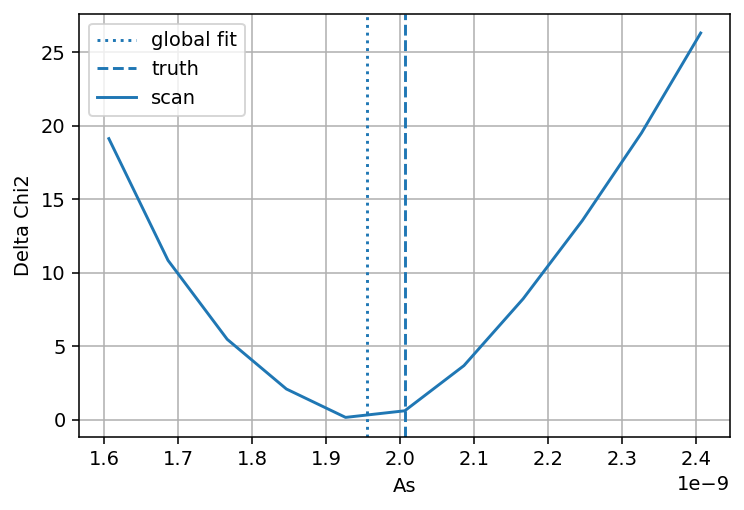

In [17]:
scan1D.plot_grid_scan(true_value=true_As)

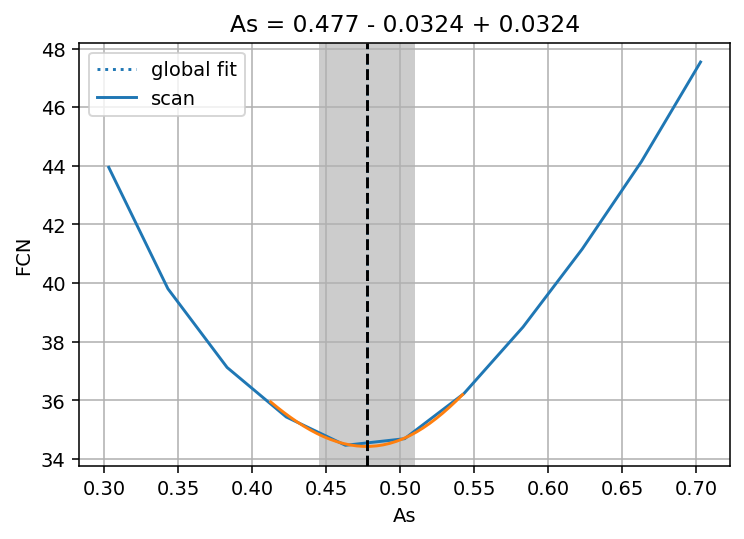

In [18]:
# compare with function from iminuit (cube values)
scan1D.plot_grid_scan(cube_values=True,yaxis='MinusLogLike')
minimizer.minimizer.draw_mnprofile(vname='As',bins=30);

### Setup a 2D chi2 scan

In [ ]:
N1=11
N2=11
grid_1={'name':'As','minval':true_As-4e-10,'maxval':true_As+4e-10,'nval':N1}
grid_2={'name':'ns','minval':true_ns-0.03,'maxval':true_ns+0.03,'nval':N2}
scan2D=grid_scanner.Scan2D(like,param_grid_1=grid_1,param_grid_2=grid_2)
# compute actual scan (might be slow)
_=scan2D.get_grid_scan()

will compute grid scan
will run migrad
------------------------------------------------------------------
| FCN = 34.42                   |     Ncalls=175 (175 total)     |
| EDM = 6.67e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
global chi2 = 0.7901801016989698 ; best-fit = [0.47733325 0.61058843 0.54056164 0.45860973 0.58181012]
0 As 1.606055e-09 in cube 0.3030275
1 ns 0.937565 in c

 /Library/Python/3.7/site-packages/numpy/linalg/linalg.py:2099: RuntimeWarning:invalid value encountered in slogdet


------------------------------------------------------------------
| FCN = 39.49                   |      Ncalls=94 (94 total)      |
| EDM = 9.4e-08 (Goal: 0.0001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
0 As 2.0860549999999998e-09 in cube 0.5430274999999999
1 ns 0.937565 in cube 0.3756499999999997
will run migrad
------------------------------------------------------------------
| FCN = 41.69    

------------------------------------------------------------------
| FCN = 36.25                   |      Ncalls=90 (90 total)      |
| EDM = 5.29e-07 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
0 As 2.006055e-09 in cube 0.5030275000000001
1 ns 0.943565 in cube 0.43564999999999976
will run migrad
------------------------------------------------------------------
| FCN = 37.48             

------------------------------------------------------------------
| FCN = 35.72                   |      Ncalls=77 (77 total)      |
| EDM = 1.58e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
0 As 1.926055e-09 in cube 0.4630275
1 ns 0.949565 in cube 0.4956499999999998
will run migrad
------------------------------------------------------------------
| FCN = 35.42                   |   

In [ ]:
scan2D.plot_grid_scan(true_values=[true_As,true_ns])

In [ ]:
# plot 1,2,3 sigma instead of 68%,95%,99.7% 
scan2D.plot_grid_scan(true_values=[true_As,true_ns],levels=[1,4,9])

In [ ]:
# compare to iminuit, using cube values, and for 1D sigmas
scan2D.plot_grid_scan(true_values=[true_As,true_ns],cube_values=True,zaxis='DeltaChi2',levels=[1,4,9])
# this will take a while, it computes several minimizations
minimizer.minimizer.draw_mncontour('As','ns',numpoints=20)

In [ ]:
minimizer.plot_ellipses('As','ns',cube_values=False)
plt.axvline(x=true_As*1e9,ls='--',color='gray',label='truth')
plt.axhline(y=true_ns,ls='--',color='gray')
plt.legend()

In [ ]:
val,err=minimizer.best_fit_value('As',return_hesse=True)

In [ ]:
err/val